# Sentiment Analysis of Reddit Comments

In [1]:
import openai
from openai.error import APIConnectionError, APIError, RateLimitError
from typing import List, Dict, Generator, Optional
import tiktoken
import pandas as pd
from dotenv import load_dotenv
import sys
import re
import random
import time
import praw
import os

import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display

In [4]:
model = "gpt-3.5-turbo"
load_dotenv(".env")
openai.api_key = os.environ["OPENAI_API_KEY"]

reddit = praw.Reddit(
    client_id=os.environ["REDDIT_CLIENT_ID"],
    client_secret=os.environ["REDDIT_CLIENT_SECRET"],
    user_agent=f"script:test:0.0.1 (by u/yourusername)",
)

In [5]:
# https://github.com/openai/openai-cookbook/blob/main/examples/How_to_count_tokens_with_tiktoken.ipynb

def num_tokens_from_messages(messages, model):
    """Returns the number of tokens used by a list of messages."""
    try:
        encoding = tiktoken.encoding_for_model(model)
    except KeyError:
        print("Warning: model not found. Using cl100k_base encoding.")
        encoding = tiktoken.get_encoding("cl100k_base")
    if model == "gpt-3.5-turbo":
        return num_tokens_from_messages(messages, model="gpt-3.5-turbo-0301")
    elif model == "gpt-4":
        return num_tokens_from_messages(messages, model="gpt-4-0314")
    elif model == "gpt-3.5-turbo-0301":
        tokens_per_message = 4  # every message follows <|start|>{role/name}\n{content}<|end|>\n
        tokens_per_name = -1  # if there's a name, the role is omitted
    elif model == "gpt-4-0314":
        tokens_per_message = 3
        tokens_per_name = 1
    else:
        raise NotImplementedError(
            f"""num_tokens_from_messages() is not implemented for model {model}. See https://github.com/openai/openai-python/blob/main/chatml.md for information on how messages are converted to tokens."""
        )
    num_tokens = 0
    for message in messages:
        num_tokens += tokens_per_message
        for key, value in message.items():
            num_tokens += len(encoding.encode(value))
            if key == "name":
                num_tokens += tokens_per_name
    num_tokens += 3  # every reply is primed with <|start|>assistant<|message|>
    return num_tokens

## Getting Reddit Comments:

In [6]:
DF_COLUMNS = ["subreddit", "submission_id", "score", "comment_body"]
# filename, subreddits = "cities.csv", [
#     "NYC",
#     "Seattle",
#     "LosAngeles",
#     "Chicago",
#     "Austin",
#     "Portland",
#     "SanFrancisco",
#     "Boston",
#     "Houston",
#     "Atlanta",
#     "Philadelphia",
#     "Denver",
#     "SeattleWa",
#     "Dallas",
#     "WashingtonDC",
#     "SanDiego",
#     "Pittsburgh",
#     "Phoenix",
#     "Minneapolis",
#     "Orlando",
#     "Nashville",
#     "StLouis",
#     "SaltLakeCity",
#     "Columbus",
#     "Raleigh",
# ]

# OTHER POTENTIAL SUBREDDITS TO TRY:
# filename, subreddits = "iphone_v_android.csv", ["iphone", "Android"]
# filename, subreddits = "startrek_v_starwars.csv", ["startrek", "StarWars"]
filename, subreddits = "epl_top_8.csv", ["reddevils", "LiverpoolFC", "chelseafc", "Gunners", "coys", "MCFC", "Everton", "NUFC"]

In [7]:
# Utility functions for fetching comments from submissions
def comment_generator(submission) -> Generator:
    # Do not bother expanding MoreComments (follow-links)
    for comment in submission.comments.list():
        if hasattr(comment, "body") and comment.body != "[deleted]" and comment.body != "[removed]":
            yield (comment)

In [9]:
def collect_comments(
    filename: str,
    target_comments_per_subreddit: int,
    max_comments_per_submission: int,
    max_comment_length: int,
    reddit: praw.Reddit,
) -> pd.DataFrame:
    """
    Collect comments from the top submissions in each subreddit.

    Cache results at cache_filename.

    Return a dataframe with columns: subreddit, submission_id, score, comment_body
    """
    try:
        df = pd.read_csv(filename, index_col="id")
        assert df.columns.tolist() == DF_COLUMNS
    except FileNotFoundError:
        df = pd.DataFrame(columns=DF_COLUMNS)

    # dict like {comment_id -> {column -> value}}
    records = df.to_dict(orient="index")

    for subreddit_index, subreddit_name in enumerate(subreddits):
        print(f"Processing Subreddit: {subreddit_name}")

        processed_comments_for_subreddit = len(df[df["subreddit"] == subreddit_name])

        if processed_comments_for_subreddit >= target_comments_per_subreddit:
            print(f"Enough comments fetched for {subreddit_name}, continuing to next subreddit.")
            continue

        # `top`` is a generator, grab submissions until we break (within this loop).
        for submission in reddit.subreddit(subreddit_name).top(time_filter="month"):
            if processed_comments_for_subreddit >= target_comments_per_subreddit:
                break

            # The number of comments that we already have for this subreddit
            processed_comments_for_submission = len(df[df["submission_id"] == submission.id])

            for comment in comment_generator(submission):
                if processed_comments_for_submission >= max_comments_per_submission or processed_comments_for_subreddit >= target_comments_per_subreddit:
                    break

                if comment.id in records:
                    print(f"Skipping comment {subreddit_name}-{submission.id}-{comment.id} because we already have it")
                    continue

                body = comment.body[:max_comment_length].strip()
                records[comment.id] = {"subreddit": subreddit_name, "submission_id": submission.id, "comment_body": body}

                processed_comments_for_subreddit += 1
                processed_comments_for_submission += 1

            # Once per post write to disk.
            print(f"CSV rewritten with {len(records)} rows.\n")
            df = pd.DataFrame.from_dict(records, orient="index", columns=DF_COLUMNS)
            df.to_csv(filename, index_label="id")

    print("Completed.")
    return df

## Sentiment Analysis on Comments:

In [16]:
MAX_ATTEMPTS = 3

def generate_prompt_messages(s: str) -> List[Dict]:
    return [
        {
            "role": "user",
            "content": """
The following is a comment from a user on Reddit. Score it from -1 to 1, where -1 is the most negative and 1 is the most positive:

The traffic is quite annoying.
""".strip(),
        },
        {"role": "assistant", "content": "-0.75"},
        {
            "role": "user",
            "content": """
The following is a comment from a user on Reddit. Score it from -1 to 1, where -1 is the most negative and 1 is the most positive:

The library is downtown.
""".strip(),
        },
        {"role": "assistant", "content": "0.0"},
        {
            "role": "user",
            "content": """
The following is a comment from a user on Reddit. Score it from -1 to 1, where -1 is the most negative and 1 is the most positive:

Even though it's humid, I really love the summertime. Everything is so green and the sun is out all the time.
""".strip(),
        },
        {"role": "assistant", "content": "0.8"},
        {
            "role": "user",
            "content": f"""
The following is a comment from a user on Reddit. Score it from -1 to 1, where -1 is the most negative and 1 is the most positive:

{s}
""".strip(),
        },
    ]

In [17]:
class UnscorableCommentError(Exception):
    pass

from tenacity import retry, wait_random_exponential, retry_if_exception_type, stop_after_attempt

@retry(
    wait=wait_random_exponential(multiplier=1, max=30),
    stop=stop_after_attempt(3),
    retry=retry_if_exception_type(UnscorableCommentError) | retry_if_exception_type(APIConnectionError) | retry_if_exception_type(APIError) | retry_if_exception_type(RateLimitError),
    reraise=True,  # Reraise the last exception
)

def score_sentiment(s: str, model: str) -> float:
    messages = generate_prompt_messages(s)
    response = openai.ChatCompletion.create(
        model=model,
        messages=messages,
    )
    score_response = response.choices[0].message.to_dict()["content"].strip()
    # This will raise an Attribute Error if the regular expression doesn't match
    try:
        return float(re.search(r"([-+]?\d*\.?\d+)", score_response).group(1))
    except AttributeError:
        raise UnscorableCommentError(f"Could not score comment: {s}")

In [18]:
# cost estimation: 
def estimate_cost_to_score_comments(df, model) -> float:
    """Estimate the number of tokens in a dataframe's comment_body column"""
    num_tokens = 0
    for comment in df["comment_body"]:
        num_tokens += num_tokens_from_messages(generate_prompt_messages(comment), model)
    return num_tokens * (0.002 / 1000) # for gpt-3.5-turbo model

In [19]:
def score_sentiments(filename: str, model: str) -> pd.DataFrame:
    """
    Score sentiments contained in comments in filename.
    """
    df = pd.read_csv(filename, index_col="id")
    assert df.columns.tolist() == DF_COLUMNS

    print(f"Scoring {len(df)} comments will cost approximately ${estimate_cost_to_score_comments(df, model):.2f}.")
    records = df.to_dict(orient="index")

    for index, item in enumerate(records.items()):
        comment_id, comment = item

        if not pd.isna(comment["score"]):
            print(f"{comment_id} was already scored. Skipping.")
            continue

        body = comment["comment_body"]
        try:
            score = score_sentiment(body, model=model)
        except UnscorableCommentError:
            # The score_sentiment method will retry 3 times before letting this error pass through.
            # If it does, we will consider this comment un-processable and skip it.
            # For other errors, such as APIConnectionError, we will fail completely and let the user know.
            continue
        print(
            f"""
            {comment_id} - ({index + 1} of {len(records)} Comments)
            Body: {body[:80]}
            Score: {score}""".strip()
        )

        records[comment_id]["score"] = score
        df = pd.DataFrame.from_dict(records, orient="index", columns=DF_COLUMNS)
        df.to_csv(filename, index_label="id")

    print("Scoring completed.")
    return df

## Plotting Sentiment:

In [22]:
def get_avg_scores_sorted(df):
    avg_scores = df.groupby("subreddit")["score"].mean().reset_index()
    avg_scores = avg_scores.sort_values("score", ascending=True)
    return avg_scores

In [23]:
# https://seaborn.pydata.org/examples/kde_ridgeplot.html
def get_avg_score_by_subreddit(dataframe):
    """
    Given a pandas DataFrame with columns "subreddit" and "score", returns a new DataFrame
    with the average score and standard deviation for each subreddit.
    """
    # Group by subreddit and calculate the mean and standard deviation for each group
    subreddit_stats = dataframe.groupby("subreddit")["score"].agg(["mean", "std"])

    # Rename columns to indicate that they represent the mean and standard deviation
    subreddit_stats.columns = ["mean_score", "standard_deviation"]

    subreddit_stats = subreddit_stats.sort_values("mean_score", ascending=True)

    # Return the new DataFrame
    return subreddit_stats

def plot_sentiments(df):
    sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

    # Create the data
    df_scores = df[["score", "subreddit"]]

    # Initialize the FacetGrid object
    pal = sns.cubehelix_palette(10, rot=-0.25, light=0.7)
    g = sns.FacetGrid(df_scores, row="subreddit", row_order=get_avg_score_by_subreddit(df_scores).index.to_list(), hue="subreddit", aspect=15, height=0.5, palette=pal)

    # Draw the densities in a few steps
    g.map(sns.kdeplot, "score", bw_adjust=0.5, clip_on=False, fill=True, alpha=1, linewidth=1.5)
    g.map(sns.kdeplot, "score", clip_on=False, color="w", lw=2, bw_adjust=0.5)

    # passing color=None to refline() uses the hue mapping
    g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

    # Define and use a simple function to label the plot in axes coordinates
    def label(x, color, label):
        ax = plt.gca()
        ax.text(0, 0.2, label, fontweight="bold", color=color, ha="left", va="center", transform=ax.transAxes)

    g.map(label, "score")

    # Set the subplots to overlap
    g.figure.subplots_adjust(hspace=-0.25)

    # Remove axes details that don't play well with overlap
    g.set_titles("")
    g.set(yticks=[], ylabel="")
    g.despine(bottom=True, left=True)

    # display(g.fig)

## Run Everything!

In [20]:
TARGET_COMMENTS_PER_SUBREDDIT = 50
MAX_COMMENTS_PER_SUBMISSION = 10
MAX_COMMENT_LENGTH = 2000

collect_comments(
    filename=filename,
    target_comments_per_subreddit=TARGET_COMMENTS_PER_SUBREDDIT,
    max_comments_per_submission=MAX_COMMENTS_PER_SUBMISSION,
    max_comment_length=MAX_COMMENT_LENGTH,
    reddit=reddit,
)

Processing Subreddit: reddevils
Enough comments fetched for reddevils, continuing to next subreddit.
Processing Subreddit: LiverpoolFC
Enough comments fetched for LiverpoolFC, continuing to next subreddit.
Processing Subreddit: chelseafc
Enough comments fetched for chelseafc, continuing to next subreddit.
Processing Subreddit: Gunners
Enough comments fetched for Gunners, continuing to next subreddit.
Processing Subreddit: coys
Enough comments fetched for coys, continuing to next subreddit.
Processing Subreddit: MCFC
Enough comments fetched for MCFC, continuing to next subreddit.
Processing Subreddit: Everton
Enough comments fetched for Everton, continuing to next subreddit.
Processing Subreddit: NUFC
Enough comments fetched for NUFC, continuing to next subreddit.
Completed.


,subreddit,submission_id,score,comment_body
id,,,,
jkr0z7j,reddevils,13lqbis,NaN,Source: https://www.instagram.com/p/Csa1f8NM7-...
jkr1710,reddevils,13lqbis,NaN,I always remember when he said no one would bo...
jkr0xqv,reddevils,13lqbis,NaN,Poor guy with all the injuries - wishing him a...
jkr1qh5,reddevils,13lqbis,NaN,"""I've said before that I found it hard to even..."
jkr1v2g,reddevils,13lqbis,NaN,"Even if injured, name him on the bench for fin..."
...,...,...,...,...
jl7ubhu,NUFC,13p50iu,NaN,Someone make this our subreddit banner please\...
jl7qp4f,NUFC,13p50iu,NaN,Nick Pope absolutely makes this photo epic! LOL!
jl7q02h,NUFC,13p50iu,NaN,Hands down best pic yet


In [21]:
df = score_sentiments(
    filename=filename,
    model=model,
)

Scoring 400 comments will cost approximately $0.20.
jkr0z7j - (1 of 400 Comments)
            Body: Source: https://www.instagram.com/p/Csa1f8NM7-f/?igshid=MzRlODBiNWFlZA==
            Score: 0.0
jkr1710 - (2 of 400 Comments)
            Body: I always remember when he said no one would bother coming to his testimonial, ex
            Score: 0.3
jkr0xqv - (3 of 400 Comments)
            Body: Poor guy with all the injuries - wishing him all the best in his future!
            Score: 0.9
jkr1qh5 - (4 of 400 Comments)
            Body: "I've said before that I found it hard to even speak to my teammates because I w
            Score: -0.9
jkr1v2g - (5 of 400 Comments)
            Body: Even if injured, name him on the bench for final home game instead of third keep
            Score: 0.9
jkr20no - (6 of 400 Comments)
            Body: I'll always remember his diving header to clear the ball away with Giroud breath
            Score: 0.65
jkr1oim - (7 of 400 Comments)
            Body: Ju

jl1grmm - (62 of 400 Comments)
            Body: alisson is all of us after he turned around. „fuck off“, yeah, we all said that.
            Score: -0.5
jl1i5g1 - (63 of 400 Comments)
            Body: For context: he was the fourth official to Tierney in the Spurs game and it was 
            Score: 0.2
jl1gzff - (64 of 400 Comments)
            Body: He's like "my wife's a doctor, mate. It's not supposed to look like that. Go ask
            Score: 0.2
jl1iulp - (65 of 400 Comments)
            Body: All I know is we complain about refs A LOT less often in CL
            Score: 0.5
jl1gotx - (66 of 400 Comments)
            Body: What a prick
            Score: -0.9
jl1h6ky - (67 of 400 Comments)
            Body: Poor Gakpo, those marks on his chest 😕 

Referee performance was horrendous yest
            Score: -0.7
jl1i8gd - (68 of 400 Comments)
            Body: Bet they won't release the footage of the VAR for this one
            Score: -0.6
jl1hpo7 - (69 of 400 Comments)
     

jkk24ij - (125 of 400 Comments)
            Body: Lukaku redemption arc starts now
            Score: 0.5
jkjxlft - (126 of 400 Comments)
            Body: It’s sick how Inter have had Pirelli on their kits since the mid 90s.
            Score: 0.6
jkk6g3u - (127 of 400 Comments)
            Body: Given his big game record what's the odds on him doing anything?

Dzeko is the h
            Score: 0.2
jkk0nzf - (128 of 400 Comments)
            Body: Bought to see the higuin special from him in the ucl
            Score: -0.5
jkjvgnp - (129 of 400 Comments)
            Body: Unless Pep starts Haaland at LB or some shit I don’t think this one will even be
            Score: -0.6
jkkduc8 - (130 of 400 Comments)
            Body: I’ve always liked being the only “new money/cash injection” club with a champion
            Score: -0.5
jkm7bu8 - (131 of 400 Comments)
            Body: Okay this is hilarious
            Score: 0.9
jkm7tec - (132 of 400 Comments)
            Body: New shirt spon

jjzrxrr - (185 of 400 Comments)
            Body: He hasn’t aged a bit it’s nuts
            Score: 0.4
jjztjk1 - (186 of 400 Comments)
            Body: Whos gonna cross post it to their sub?
            Score: -0.3
jjzp8nw - (187 of 400 Comments)
            Body: Great, now I have to imagine Mikel with a pacifier and you all have to as well
            Score: -0.6
jjzut0e - (188 of 400 Comments)
            Body: Agent Iwobi to the rescue.
            Score: 0.6
jjzvj1q - (189 of 400 Comments)
            Body: Repost to the Everton Sub, STAT
            Score: -0.5
jk0mkdk - (190 of 400 Comments)
            Body: A toffee here. Believe me if we can secure safety while helping a team that’s no
            Score: 0.1
jlyus2i - (191 of 400 Comments)
            Body: You know what's next. 

F5 every 5 mins till transfer window closes.
            Score: 0.2
jlytx0i - (192 of 400 Comments)
            Body: This team will be remembered as the team which set the foundation for one of t

jn02nnm - (247 of 400 Comments)
            Body: What a cunt ❤️
            Score: -0.9
jn01lm3 - (248 of 400 Comments)
            Body: Here we fucking go finally.
            Score: -0.7
jn01lmo - (249 of 400 Comments)
            Body: I’m excited. Lets get behind him and whoever is in the squad after the off-seaso
            Score: 0.7
jn01qi4 - (250 of 400 Comments)
            Body: Get Tommy the fucking Aussie in while we’re at it.
            Score: -0.9
jkyrfzg - (251 of 400 Comments)
            Body: Remember to report and move on. Oil is thicker than blood. ™️🛢️🛢️🛢️
            Score: 0.3
jkxmt8q - (252 of 400 Comments)
            Body: YES!! 1 down 2 to go!!!!!
            Score: 0.5
jkxmvqw - (253 of 400 Comments)
            Body: https://preview.redd.it/vyi8pq59n21b1.jpeg?width=630&format=pjpg&auto=webp&v=ena
            Score: 0.0
jkxn1re - (254 of 400 Comments)
            Body: Sterling's going to have to give City a guard of honor tomorrow if he starts 😳
       

jm0n4lw - (307 of 400 Comments)
            Body: All is forgiven for his tackle on Richarlison last season
            Score: -0.5
jm0ldv4 - (308 of 400 Comments)
            Body: Between him and Pickford for player of the season for me, although I’d edge towa
            Score: 0.4
jm16qik - (309 of 400 Comments)
            Body: Second only to Pickford as my player of the season. Being the only outfield play
            Score: 0.9
jm0sc1w - (310 of 400 Comments)
            Body: I knew he was reliable but hadn't known he was this reliable until the announcer
            Score: 0.6
jlyw07j - (311 of 400 Comments)
            Body: Should we do a chart from the beginning of the year next season just to see how 
            Score: 0.4
jlyvv1p - (312 of 400 Comments)
            Body: ALL HAIL THE CHART
            Score: -0.5
jlyxp8h - (313 of 400 Comments)
            Body: The “A point would be lucky” points are what really saved us.
            Score: -0.5
jlz0g0x - (314 of 400 C

jkosh85 - (369 of 400 Comments)
            Body: Murphy has spent the whole game warming up his jaws. 

 Wider than ever.
            Score: -0.7
jkor24v - (370 of 400 Comments)
            Body: Who is arthur?
            Score: 0.0
jmn3gox - (371 of 400 Comments)
            Body: Welcome to [r/NUFC!](https://reddit.com/r/nufc)

[Join our Discord Server](https
            Score: 0.4
jmn4w9f - (372 of 400 Comments)
            Body: I can't decide if I love the pass, the run, the touch or the finish the most. It
            Score: 0.9
jmn4e8v - (373 of 400 Comments)
            Body: That first touch. Just instantly killed all movement on the ball except exactly 
            Score: 0.9
jmn50oc - (374 of 400 Comments)
            Body: Everything about this is sexy as fuck: Fabian Schar, Fabian Schar's pass, Big Jo
            Score: 0.95
jmn4hze - (375 of 400 Comments)
            Body: I can't believe he's gone from a player we'd given up on to a crucial member of 
            Score

/Users/qingyingmeng/Desktop/side-projects/SentimentMap/env/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/Users/qingyingmeng/Desktop/side-projects/SentimentMap/env/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/Users/qingyingmeng/Desktop/side-projects/SentimentMap/env/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/Users/qingyingmeng/Desktop/side-projects/SentimentMap/env/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: Tight layout not appli

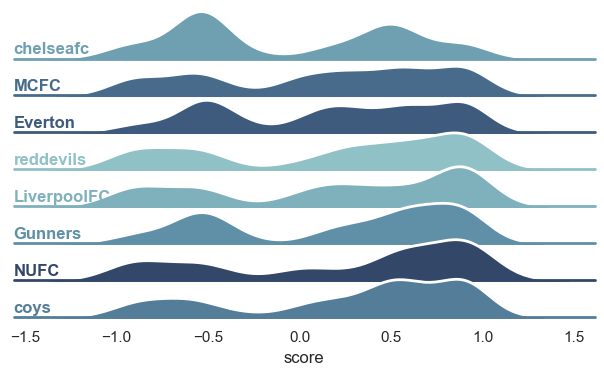

In [24]:
plot_sentiments(df)